# Concept Drift Analysis for Fraud Detection Data

This notebook investigates potential concept drift in the IEEE-CIS Fraud Detection dataset. Concept drift occurs when the statistical properties of the target variable or the input features change over time, which can significantly degrade the performance of models trained on older data when predicting on newer data.

We analyze:
1.  **Target Drift:** How the overall fraud rate changes over time.
2.  **Feature Drift:** How the distributions of key numerical and categorical features change over time.

This analysis uses the raw training data *before* splitting to visualize trends across the entire available timeline.

## 1. Setup and Configuration

In [ ]:
%pip install matplotlib seaborn

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path
from tqdm.notebook import tqdm # Use notebook version for better display

# --- Configuration ---
# Adjust path to go up one level from /notebooks to project root
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))
print(f"Project Root: {project_root}")
print(f"Python Path: {sys.path}")

# Attempt to import config from the src directory
try:
    import src.config as config
    print("Successfully imported src.config")
except ModuleNotFoundError:
    print("Error: Could not import src.config. Make sure config.py exists in the 'src' directory relative to the project root.")
    # Define essential variables manually if config fails (adjust paths/names)
    config = type('obj', (object,), {
        'RAW_DATA_DIR': os.path.join(project_root, "data", "raw"),
        'TRANSACTION_FILE_TRAIN': os.path.join(project_root, "data", "raw", "train_transaction.csv"),
        'IDENTITY_FILE_TRAIN': os.path.join(project_root, "data", "raw", "train_identity.csv"),
        'ID_COL': 'TransactionID',
        'TARGET_COL': 'isFraud',
        'TIMESTAMP_COL': 'TransactionDT',
        # Add key features identified from XGBoost or domain knowledge
        'KEY_NUM_FEATURES': ['TransactionAmt', 'C1', 'D1', 'D15'], # Example numerical
        'KEY_CAT_FEATURES': ['ProductCD', 'card4', 'M4', 'id_31']  # Example categorical
    })()
    print("Using manually defined config variables.")

# --- Plotting Style ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
tqdm.pandas() # Enable progress bars for pandas apply

# --- Parameters ---
# Set to None to load all data (might require significant RAM)
N_ROWS_TO_LOAD = 200000 # Load a subset for faster analysis, None for full dataset
N_TIME_BINS = 10 # How many time periods to divide the data into

Project Root: /Users/aca/UoL/final/fdgnn
Python Path: ['/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/opt/homebrew/Cellar/python@3.11/3.11.11/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/aca/UoL/final/fdgnn/.venv/lib/python3.11/site-packages', '/Users/aca/UoL/final/fdgnn']
Successfully imported src.config


## 2. Data Loading and Preparation

In [4]:
def load_and_merge(trans_path, id_path, id_col, nrows=None):
    """Loads and merges transaction and identity data."""
    print(f"Loading data... (nrows={nrows})")
    try:
        print(f"  Loading transactions: {trans_path}")
        df_trans = pd.read_csv(trans_path, nrows=nrows)
        print(f"  Loading identity: {id_path}")
        df_id = pd.read_csv(id_path, nrows=nrows) # Load corresponding IDs if sampling trans

        print(f"  Merging data on '{id_col}'...")
        # Use TransactionID from config
        df = pd.merge(df_trans, df_id, on=id_col, how='left')
        print(f"Data loaded and merged. Shape: {df.shape}")
        # Basic memory usage check
        mem_usage = df.memory_usage(index=True).sum()
        print(f"Memory usage: {mem_usage / 1024**2:.2f} MB")
        return df
    except FileNotFoundError as e:
        print(f"Error loading data: {e}. Make sure files exist at specified paths.")
        raise
    except Exception as e:
        print(f"An unexpected error occurred during loading: {e}")
        raise

In [5]:
# Load the data
df_full = load_and_merge(
    config.TRANSACTION_FILE_TRAIN,
    config.IDENTITY_FILE_TRAIN,
    config.ID_COL,
    nrows=N_ROWS_TO_LOAD
)

Loading data... (nrows=200000)
  Loading transactions: /Users/aca/UoL/final/fdgnn/data/raw/train_transaction.csv
  Loading identity: /Users/aca/UoL/final/fdgnn/data/raw/train_identity.csv
  Merging data on 'TransactionID'...
Data loaded and merged. Shape: (200000, 434)
Memory usage: 662.23 MB


In [6]:
# --- Time Feature Preparation ---
# TransactionDT is seconds from a reference point. Convert to days for easier interpretation.
if config.TIMESTAMP_COL in df_full.columns:
    min_dt = df_full[config.TIMESTAMP_COL].min()
    df_full['TransactionDays'] = (df_full[config.TIMESTAMP_COL] - min_dt) / (3600 * 24)
    # Create time bins
    # Using qcut for equal-sized bins based on number of samples
    try:
        df_full['TimeBin'] = pd.qcut(df_full['TransactionDays'], q=N_TIME_BINS, labels=False, duplicates='drop')
        # Or use pd.cut for equal width bins:
        # df_full['TimeBin'] = pd.cut(df_full['TransactionDays'], bins=N_TIME_BINS, labels=False, include_lowest=True)
        print(f"\nCreated {df_full['TimeBin'].nunique()} time bins based on 'TransactionDays'.")
        print("Time Bin Distribution:")
        print(df_full['TimeBin'].value_counts().sort_index())
    except Exception as e:
        print(f"Error creating time bins: {e}. Check N_TIME_BINS and TransactionDays distribution.")
        # Handle error, maybe skip time-based analysis
else:
    print(f"Error: Timestamp column '{config.TIMESTAMP_COL}' not found. Cannot perform time-based analysis.")
    # Handle error


Created 10 time bins based on 'TransactionDays'.
Time Bin Distribution:
TimeBin
0    20000
1    20000
2    20000
3    20000
4    20000
5    20000
6    20000
7    20000
8    20000
9    20000
Name: count, dtype: int64


## 3. Target Variable Drift Analysis


Analyzing drift for target variable: 'isFraud'


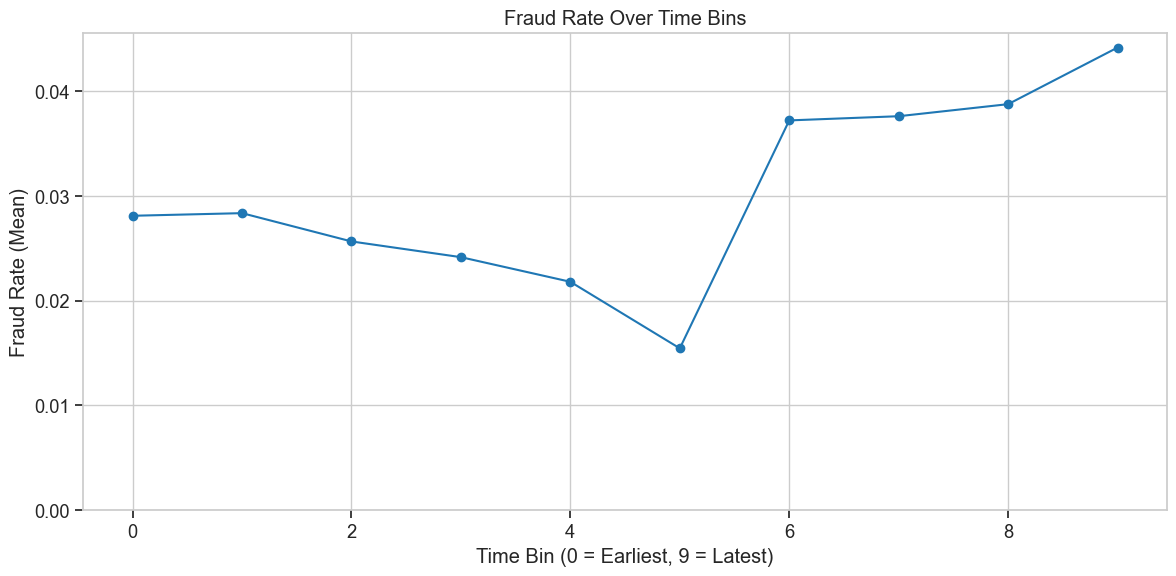


Fraud Rate per Bin:
TimeBin
0    0.02810
1    0.02835
2    0.02565
3    0.02415
4    0.02180
5    0.01545
6    0.03720
7    0.03760
8    0.03875
9    0.04415
Name: isFraud, dtype: float64


In [7]:
if config.TARGET_COL in df_full.columns and 'TimeBin' in df_full.columns:
    print(f"\nAnalyzing drift for target variable: '{config.TARGET_COL}'")
    # Calculate fraud rate per time bin
    fraud_rate_over_time = df_full.groupby('TimeBin')[config.TARGET_COL].mean()

    # Plotting
    plt.figure(figsize=(12, 6))
    fraud_rate_over_time.plot(marker='o', linestyle='-')
    plt.title('Fraud Rate Over Time Bins')
    plt.xlabel(f'Time Bin (0 = Earliest, {N_TIME_BINS-1} = Latest)')
    plt.ylabel('Fraud Rate (Mean)')
    plt.ylim(bottom=0) # Ensure y-axis starts at 0
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nFraud Rate per Bin:")
    print(fraud_rate_over_time)
else:
    print(f"Cannot analyze target drift: Target column '{config.TARGET_COL}' or 'TimeBin' column missing.")

**Interpretation:** 
The fraud rate starts around 2.8%, decreases slightly, reaching a minimum around Time Bin 5 (approx 1.5%). There's a dramatic jump in fraud rate between Time Bin 5 and Time Bin 6 (more than doubling). The rate continues to climb steadily in the later time bins (7, 8, 9), ending significantly higher (around 4.5%) than where it started.

**Conclusion**: This is strong evidence of target drift. The fundamental probability of a transaction being fraudulent changes considerably over the dataset's timespan.


## 4. Feature Drift Analysis

### 4.1 Numerical Features


Analyzing drift for numerical features: ['TransactionAmt', 'dist1', 'C1', 'C2', 'D2', 'D3', 'id_01', 'id_02', 'V1', 'V3']
Found numerical features: ['TransactionAmt', 'dist1', 'C1', 'C2', 'D2', 'D3', 'id_01', 'id_02', 'V1', 'V3']
  Plotting distribution for 'TransactionAmt'...
  Plotting distribution for 'dist1'...
  Plotting distribution for 'C1'...
  Plotting distribution for 'C2'...
  Plotting distribution for 'D2'...
  Plotting distribution for 'D3'...
  Plotting distribution for 'id_01'...
  Plotting distribution for 'id_02'...
  Plotting distribution for 'V1'...
  Plotting distribution for 'V3'...


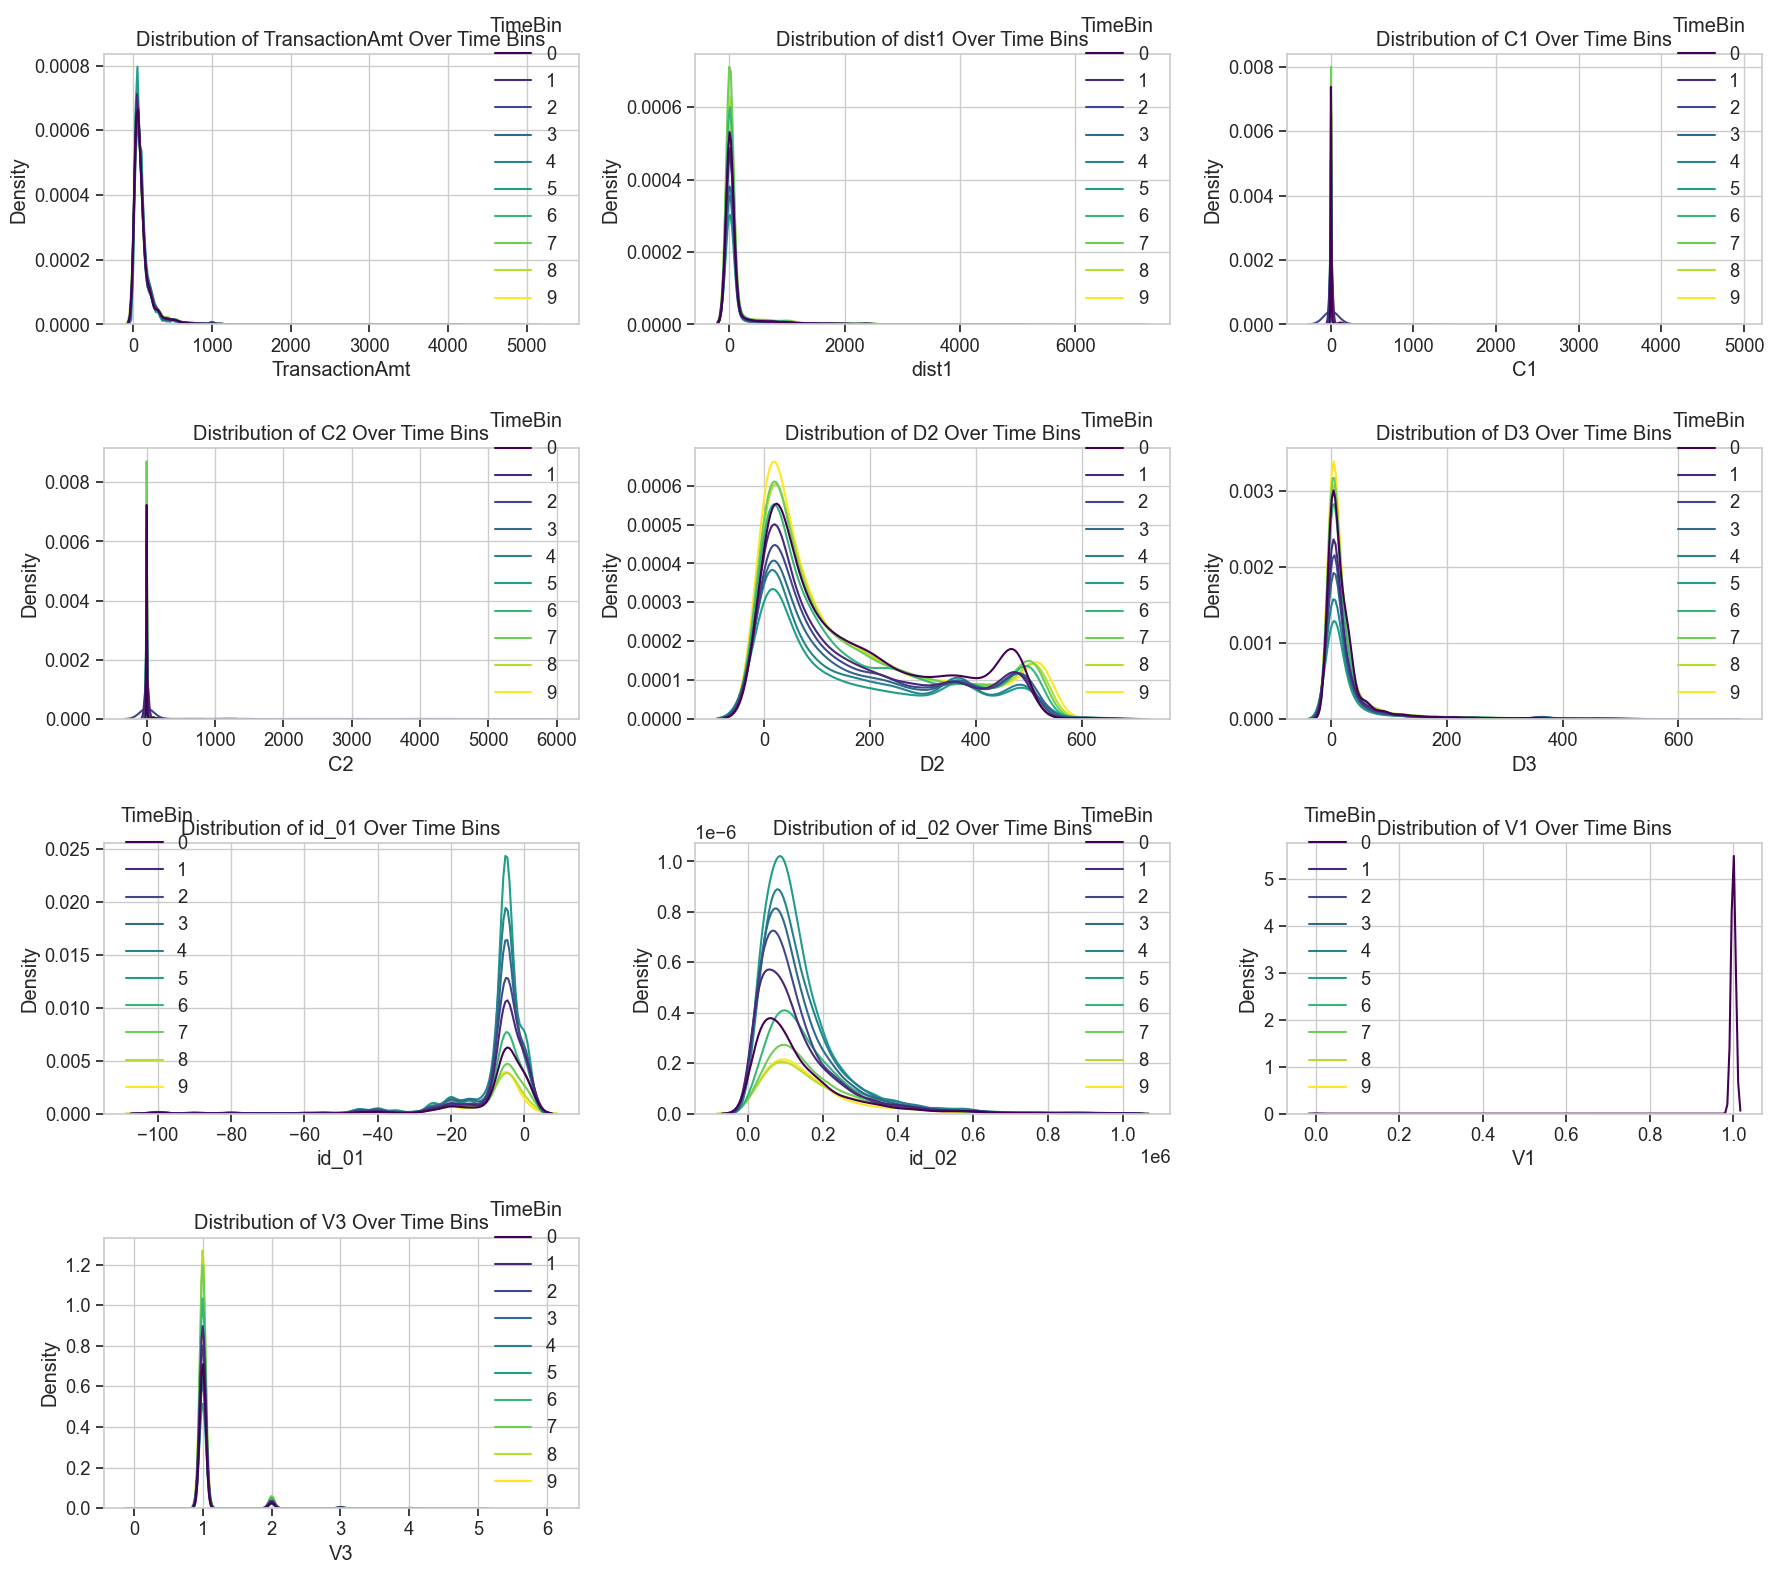

  Plotting mean/median for 'TransactionAmt'...
  Plotting mean/median for 'dist1'...
  Plotting mean/median for 'C1'...
  Plotting mean/median for 'C2'...
  Plotting mean/median for 'D2'...
  Plotting mean/median for 'D3'...
  Plotting mean/median for 'id_01'...
  Plotting mean/median for 'id_02'...
  Plotting mean/median for 'V1'...
  Plotting mean/median for 'V3'...


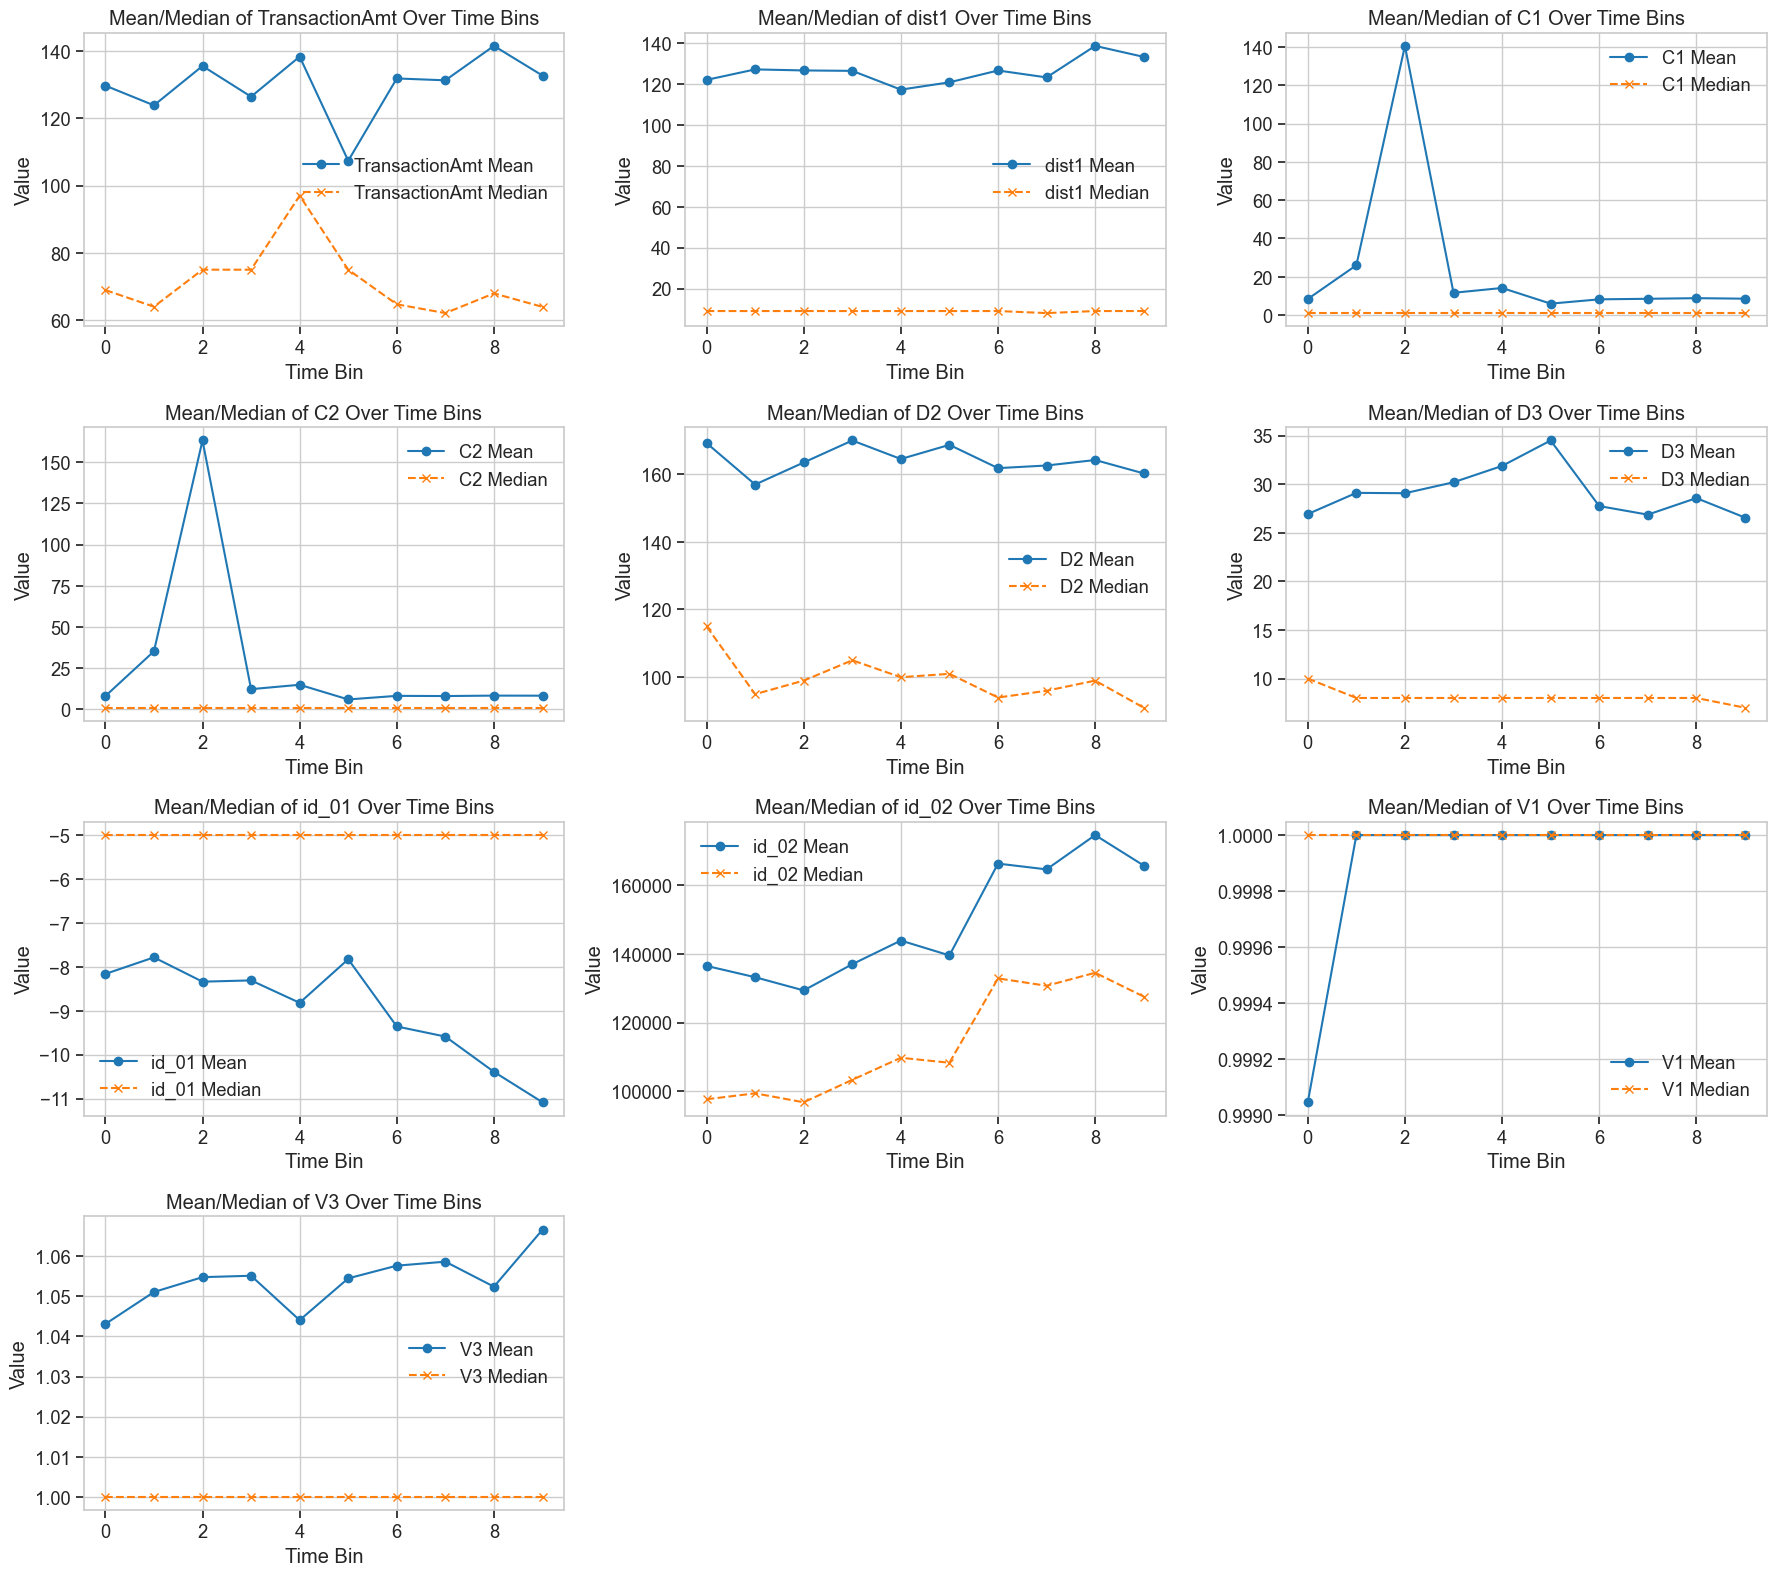

In [8]:
if 'TimeBin' in df_full.columns:
    print(f"\nAnalyzing drift for numerical features: {config.KEY_NUM_FEATURES}")
    numerical_features_present = [f for f in config.KEY_NUM_FEATURES if f in df_full.columns]
    if not numerical_features_present:
        print("None of the specified key numerical features found in the data.")
    else:
        print(f"Found numerical features: {numerical_features_present}")
        n_num_features = len(numerical_features_present)
        n_cols_plot = 3 # Adjust layout
        n_rows_plot = (n_num_features + n_cols_plot - 1) // n_cols_plot

        fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(n_cols_plot * 6, n_rows_plot * 4))
        axes = axes.flatten() # Flatten axes array for easy iteration

        for i, feature in enumerate(numerical_features_present):
            ax = axes[i]
            print(f"  Plotting distribution for '{feature}'...")
            # Using KDE plot for distribution comparison
            sns.kdeplot(data=df_full, x=feature, hue='TimeBin', palette='viridis', ax=ax, warn_singular=False)
            # Or use histograms:
            # for bin_val in df_full['TimeBin'].unique():
            #     sns.histplot(df_full[df_full['TimeBin'] == bin_val][feature], ax=ax, label=f'Bin {bin_val}', kde=True, stat='density', common_norm=False)
            # ax.legend()

            ax.set_title(f'Distribution of {feature} Over Time Bins')
            ax.set_xlabel(feature)
            ax.set_ylabel('Density')

        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

        # --- Plot Mean/Median Over Time ---
        fig_agg, axes_agg = plt.subplots(n_rows_plot, n_cols_plot, figsize=(n_cols_plot * 6, n_rows_plot * 4))
        axes_agg = axes_agg.flatten()

        for i, feature in enumerate(numerical_features_present):
             ax = axes_agg[i]
             print(f"  Plotting mean/median for '{feature}'...")
             mean_over_time = df_full.groupby('TimeBin')[feature].mean()
             median_over_time = df_full.groupby('TimeBin')[feature].median()
             mean_over_time.plot(ax=ax, marker='o', linestyle='-', label=f'{feature} Mean')
             median_over_time.plot(ax=ax, marker='x', linestyle='--', label=f'{feature} Median')
             ax.set_title(f'Mean/Median of {feature} Over Time Bins')
             ax.set_xlabel(f'Time Bin')
             ax.set_ylabel('Value')
             ax.legend()
             ax.grid(True)

        # Hide unused subplots
        for j in range(i + 1, len(axes_agg)):
            fig_agg.delaxes(axes_agg[j])

        plt.tight_layout()
        plt.show()

else:
    print("Cannot analyze numerical feature drift: 'TimeBin' column missing.")

**Interpretation:** 
Strong Confirmation of concept Drift: The analysis clearly shows significant changes over time in several key input features (D2, D3, id_01, id_02, TransactionAmt median).

### 4.2 Categorical Features


Analyzing drift for categorical features: ['ProductCD', 'id_13', 'id_14', 'M1', 'M4', 'id_15', 'id_34']
Found categorical features: ['ProductCD', 'id_13', 'id_14', 'M1', 'M4', 'id_15', 'id_34']
  Plotting proportions for 'ProductCD'...
  Plotting proportions for 'id_13'...
    Feature 'id_13' has high cardinality (46). Showing top 10.
  Plotting proportions for 'id_14'...
    Feature 'id_14' has high cardinality (25). Showing top 10.
  Plotting proportions for 'M1'...
  Plotting proportions for 'M4'...
  Plotting proportions for 'id_15'...
  Plotting proportions for 'id_34'...


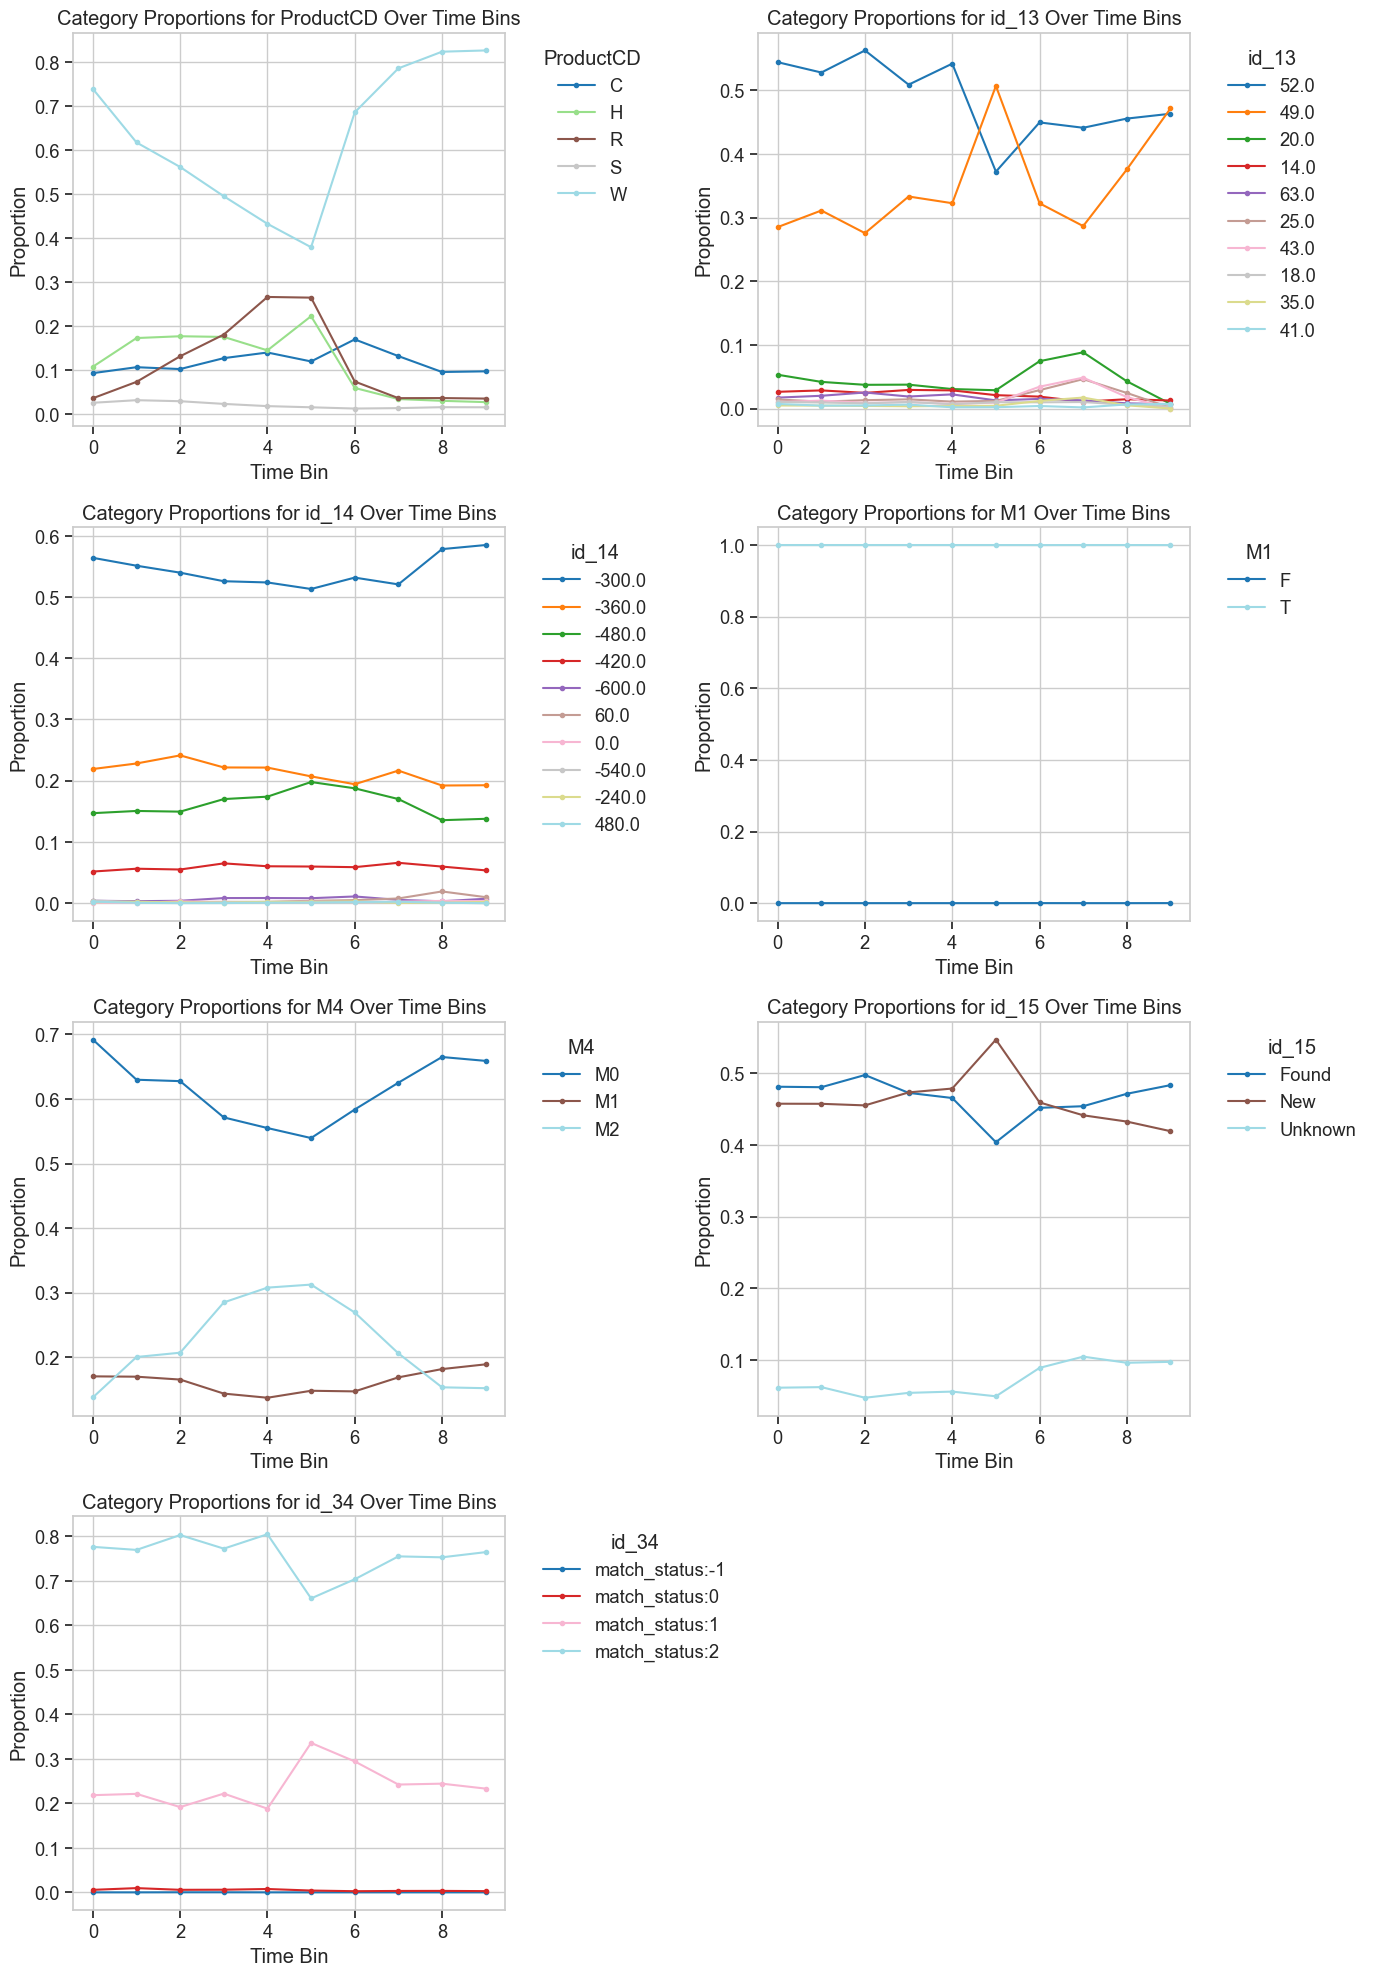

In [9]:
if 'TimeBin' in df_full.columns:
    print(f"\nAnalyzing drift for categorical features: {config.KEY_CAT_FEATURES}")
    categorical_features_present = [f for f in config.KEY_CAT_FEATURES if f in df_full.columns]

    if not categorical_features_present:
        print("None of the specified key categorical features found in the data.")
    else:
        print(f"Found categorical features: {categorical_features_present}")
        n_cat_features = len(categorical_features_present)
        n_cols_plot = 2 # Adjust layout
        n_rows_plot = (n_cat_features + n_cols_plot - 1) // n_cols_plot

        fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(n_cols_plot * 7, n_rows_plot * 5))
        axes = axes.flatten()

        for i, feature in enumerate(categorical_features_present):
            ax = axes[i]
            print(f"  Plotting proportions for '{feature}'...")
            # Calculate proportion of each category within each time bin
            # Fillna for plotting stability if categories appear/disappear
            proportions = df_full.groupby('TimeBin')[feature].value_counts(normalize=True).unstack(fill_value=0)

            # Limit number of categories shown for clarity if cardinality is high
            max_cats_to_show = 10
            if proportions.shape[1] > max_cats_to_show:
                print(f"    Feature '{feature}' has high cardinality ({proportions.shape[1]}). Showing top {max_cats_to_show}.")
                # Get top categories based on overall frequency
                top_cats = df_full[feature].value_counts().nlargest(max_cats_to_show).index
                proportions = proportions[top_cats]

            proportions.plot(kind='line', marker='.', ax=ax, colormap='tab20') # Line plot often clearer than stacked bar for many categories
            # Or use stacked bar: proportions.plot(kind='bar', stacked=True, ax=ax, colormap='tab20')

            ax.set_title(f'Category Proportions for {feature} Over Time Bins')
            ax.set_xlabel('Time Bin')
            ax.set_ylabel('Proportion')
            ax.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, axis='y')

        # Hide unused subplots
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.tight_layout()
        plt.show()

else:
    print("Cannot analyze categorical feature drift: 'TimeBin' column missing.")

**Interpretation:** Look at the line plots (or stacked bars). Do the proportions of different categories within a feature change significantly over time? For example, does one `ProductCD` become much more or less common? Does the usage of certain `card4` types shift? Changes in these proportions indicate feature drift.

## 5. Conclusion

#### Target Drift

There is **significant target drift**. The overall fraud rate is non-stationary. It initially decreases from ~2.8% to a low of ~1.5% around the middle time bins (bin 5) before sharply increasing to finish significantly higher (~4.5%) in the latest time bins. This indicates that the underlying propensity for fraud changes considerably over the dataset's duration.

#### Feature Drift
Widespread feature drift is evident across both numerical and categorical features
    *   **Numerical Features:** Significant drift was observed in `id_01` (strong downward trend in mean), `id_02` (strong upward trend in mean and median), `D2` (changing distribution shape), and `D3` (downward trend in median). `TransactionAmt` showed an increasing median over time. Features like `C1` and `C2` exhibited drift primarily in their extreme values (mean spikes) rather than their median. Features like `dist1`, `V1`, and `V3` appeared relatively stable.
    *   **Categorical Features:** Significant drift was observed in `ProductCD` (large shifts in proportions of 'W' and 'C'), `M4` (shifts between 'M0' and 'M2'), `id_15` (oscillations between 'Found' and 'New'), and `id_34` (shifts in 'match_status:1' and 'match_status:2'). Moderate drift was seen in `id_13` and `id_14`. Features like `M1` were extremely stable.

#### Implications
The pronounced concept drift (both target and feature drift) strongly explains the observed performance discrepancy where models perform well on validation data (temporally closer to training) but poorly on test data (temporally distant). Models trained on the earlier data distribution learn patterns and feature relationships that become less relevant or even misleading as the underlying data characteristics and fraud mechanisms shift over time. This non-stationarity poses a fundamental challenge for generalization and underscores the critical need for time-aware validation strategies, continuous monitoring, frequent model retraining, and potentially the development of adaptive models or time-robust features in practical fraud detection systems.
